# Reduced Basis Method on a Quantum Computer

Author(s): Kyle Godbey, Pablo Giuliani

Maintainer: Kyle Godbey

Now it's time to take the two level representation we just solved classically and implement it for use on quantum hardware. The bulk of this notebook is based on the VQE example for the deuteron, so check that out for more descriptions [here](../vqe/general.ipynb).

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import scipy as sci
import pennylane as qml
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
import time
from functools import partial
import warnings
warnings.filterwarnings('ignore')

We'll also need some helper functions to parse Pauli strings and construct our pennylane Hamiltonian, so I'll just dump them here along with the helpers from the previous example.

In [8]:
def pauli_token_to_operator(token):
    qubit_terms = []

    for term in range(len(token)):
        # Special case of identity
        if token[term] == "I":
            pass
        else:
            #pauli, qubit_idx = term, term
            if token[term] == "X":
                qubit_terms.append(qml.PauliX(int(term)))
            elif token[term] == "Y":
                qubit_terms.append(qml.PauliY(int(term)))
            elif token[term] == "Z":
                qubit_terms.append(qml.PauliZ(int(term)))
            else:
                print("Invalid input.")
    if(qubit_terms==[]):
            qubit_terms.append(qml.Identity(0))
    full_term = qubit_terms[0]
    for term in qubit_terms[1:]:
        full_term = full_term @ term

    return full_term


def parse_hamiltonian_input(input_data):
    # Get the input
    coeffs = []
    pauli_terms = []
    chunks = input_data.split("\n")
    # Go through line by line and build up the Hamiltonian
    for line in chunks:
        #line = line.strip()
        tokens = line.split(" ")
        # Parse coefficients
        sign, value = tokens[0][0], tokens[1]

        coeff = float(value)
        if sign == "-":
            coeff *= -1
        coeffs.append(coeff)

        # Parse Pauli component
        pauli = tokens[3]
        
        pauli_terms.append(pauli_token_to_operator(pauli))

    return qml.Hamiltonian(coeffs, pauli_terms)

### NOTE: hbar = 1 in this demo
### First define exact solutions to compare numerical solutions to.
def V(x,alpha):
    '''
    1-d harmonic Oscillator potential

    Parameters
    ----------
    x : float or nd array
        position.
    alpha : float
        oscillator length parameter.

    Returns
    -------
    float or ndarray
        value of potential evaluated at x.

    '''
    return alpha*x**2
def construct_H(V,grid,mass,alpha):
    '''
    Uses 2nd order finite difference scheme to construct a discretized differential H operator
    Note: mass is fixed to 1 for this demo.

    Parameters
    ----------
    V : TYPE
        DESCRIPTION.
        
    alpha : TYPE
        oscillator parameter alpha used in V(x) = alpha*x**2.

    Returns
    -------
    H : ndarray
        2d numpy array
    '''
    dim = len(grid)
    off_diag = np.zeros(dim)
    off_diag[1] = 1
    H = -1*(-2*np.identity(dim) + sci.linalg.toeplitz(off_diag))/(mass*h**2) + np.diag(V(grid,alpha))
    return H
def solve(H,grid,h):
    '''
    Parameters
    ----------
    H : 2d ndarray
        Hamiltonian Matrix.
    grid : ndarray
        Discretized 1d domain.
    h : float
        grid spacing.

    Returns
    -------
    evals : ndarray
        returns nd array of eigenvalues of H. 
    evects : ndarray
        returns ndarray of eigenvectors of H.
    Eigenvalues and eigenvectors are ordered in ascending order. 
    '''
    evals,evects = np.linalg.eigh(H)
    evects = evects.T
    for i,evect in enumerate(evects):
        #norm = np.sqrt(1/sci.integrate.simpson(evect*evect,grid))
        norm = 1/(np.linalg.norm(np.dot(evect,evect)))
        evects[i] = evects[i]*norm
    return evals,evects

Just like in the other examples, we'll need a pennylane compatible Hamiltonian given a requested basis dimension, N. For this problem however we'll pass a matrix with the matrix elements in directly.

In [24]:
def ham(N,mat_ele,mapper=JordanWignerMapper):
    # Start out by zeroing what will be our fermionic operator
    op = 0
    for i in range(N):
        for j in range(N):
            # Construct the terms of the Hamiltonian in terms of creation/annihilation operators 
            op +=  float(mat_ele[i][j]) * \
            FermionicOp([([("+", i),("-", j)], 1.0)])

    hamstr = "+ "+str(mapper().map(second_q_op=op))

    hamiltonian = parse_hamiltonian_input(hamstr)

    return hamiltonian 


For the last bit of classical setup, we will define our parameters, along with the alpha values we want to inform our basis. We won't plot them again here, since they will be the same as before.

This is where we'll choose our basis size too, but we'll stick with two for now to be consistent.

In [12]:
nbasis = 2

h = 10**(-2) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).

### HO global parameters 
n = 0 # principle quantum number to solve in HO
mass = 1.0 # mass for the HO system

# define the domain boundaries
x_a = -10 # left boundary 
x_b = 10 # right boundary 
x_array = np.arange(x_a,x_b+h,h)
m = len(x_array) 

# Select alpha values to use to solve SE exactly.
alpha_vals = [.5,1,2,5,15]  #Here, we choose 5 values of alpha to solve exactly. This results in 3 basis functions
# initialize solution arrays. T is the matrix that will hold wavefunction solutions. 
# T has the form T[i][j], i = alpha, j = solution components
T = np.zeros((len(alpha_vals),m)) 
# T_evals holds the eigenvalues for each evect in T. 
T_evals = np.zeros(len(alpha_vals))

for i,alpha_sample in enumerate(alpha_vals):
    H = construct_H(V,x_array,mass,alpha_sample) # construct the Hamiltonian matrix for given alpha_sample.
    evals, evects = solve(H,x_array,h) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {evals[n]}')

U, s, Vh = np.linalg.svd(T)
phi = []
for i in range(nbasis):
    phi.append(-1*Vh[i])

print("Basis constructed!")


alpha = 0.5, lambda = 0.7071036561722082
alpha = 1, lambda = 0.9999937499607756
alpha = 2, lambda = 1.4142010622630583
alpha = 5, lambda = 2.236036727063778
alpha = 15, lambda = 3.872889593938531


The last bit of housekeeping will involved us constructing our effective Hamiltonian for this two particle system again, just as the previous example.

In [45]:
dim0 = len(x_array)
off_diag = np.zeros(dim0)
off_diag[1] = 1

H0=-1*(-2*np.identity(dim0) + sci.linalg.toeplitz(off_diag))/(mass*h**2) 
H1=np.diag(V(x_array,1))

tildeH0=np.zeros((nbasis,nbasis))
tildeH1=np.zeros((nbasis,nbasis))

for i in range(nbasis):
    for j in range(nbasis):
        tildeH0[i][j] = np.dot(phi[i],np.dot(H0,phi[j]))
        tildeH1[i][j] = np.dot(phi[i],np.dot(H1,phi[j]))

def tildeH(alpha):
    return tildeH0+alpha*tildeH1

def systemSolver(alpha):
    resultssystem= np.linalg.eig(tildeH(alpha))
    if resultssystem[1][0][0]<0:
        resultssystem[1][0]=resultssystem[1][0]*(-1)
    if resultssystem[1][1][0]<0:
        resultssystem[1][1]=resultssystem[1][1]*(-1)   
    return resultssystem

def phibuilder(coefficients):
    return coefficients[0]*phi[0]+coefficients[1]*phi[1]

Now we can get into the quantum side of things! We'll be defining our ansatz in a general way, but we've included a simpler ansatz as well. 

For the Hamiltonian we'll use the helper function we just made to get the matrix elements and build our quantum-ready problem.

In [38]:
# Set alpha

alph = 3

# Set the order you'd like to go to

dim = nbasis

dev = qml.device("default.qubit", wires=dim)

# Define a general ansatz for arbitrary numbers of dimensions

particles = 1

ref_state = qml.qchem.hf_state(particles, dim)

gen_ansatz = partial(qml.ParticleConservingU2, init_state=ref_state)

layers = dim 

def ansatz(params,wires):
    t0 = params[0]
    qml.PauliX(wires=0)
    qml.RY(t0, wires=1)
    qml.CNOT(wires=[1,0])

# generate the cost function
@qml.qnode(dev)
def prob_circuit(params,ansatz):
    gen_ansatz(params, wires=dev.wires)
    return qml.probs(wires=dev.wires)

# Defining Hamiltonian

mat_ele = tildeH(3)

H = ham(dim, mat_ele)

print(H)

cost_fn = qml.ExpvalCost(gen_ansatz, H, dev)


  (-4.410191127127622) [Z0]
+ (-0.8896021203241673) [Z1]
+ (5.29979324745179) [I0]
+ (0.15260766982052604) [Y0 Y1]
+ (0.15260766982052604) [X0 X1]


We're definitely on the right track, now to do the VQE.

Let's set up our initial parameters.

In [26]:
# Our parameter array

init_params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=qml.ParticleConservingU2.shape(n_layers=layers, n_wires=dim))
#init_params = np.array([2.5,])
print(init_params)
# Convergence information and step size

max_iterations = 500
conv_tol = 1e-05
step_size = 0.1

[[-0.26431553  1.56421467 -0.72486966]
 [ 0.22206864  1.48369176  0.27560091]]


And now the VQE loop just as the other examples.

In [31]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

accel = 0
prev_conv = -1.0

start = time.time()

for n in range(max_iterations):
    fac = (1.0)
    opt = qml.GradientDescentOptimizer(stepsize=step_size)

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if(energy - prev_energy > 0.0 and step_size > 0.001):
        #print("Lowering!")
        accel = 0
        step_size = 0.5*step_size

    if(conv < prev_conv): accel += 1
    prev_conv = conv
    
    if(accel > 10 and step_size < 1.0):
        #print("Accelerating!")
        step_size = 1.1*step_size
    end = time.time()

    if n % 1 == 0:
        print(
            "It = {:},  Energy = {:.8f},  Conv = {"
            ":.8f}, Time Elapsed = {:.3f} s".format(n, energy, conv,end-start)
        )
        start = time.time()


    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f}".format(energy))
print("Number of iterations = ", n)

It = 0,  Energy = 2.17444824,  Conv = 3.75581526, Time Elapsed = 0.080 s
It = 1,  Energy = 1.78873834,  Conv = 0.38570989, Time Elapsed = 0.082 s
It = 2,  Energy = 1.76919789,  Conv = 0.01954046, Time Elapsed = 0.075 s
It = 3,  Energy = 1.76702497,  Conv = 0.00217291, Time Elapsed = 0.083 s
It = 4,  Energy = 1.76638898,  Conv = 0.00063599, Time Elapsed = 0.075 s
It = 5,  Energy = 1.76614987,  Conv = 0.00023911, Time Elapsed = 0.072 s
It = 6,  Energy = 1.76605742,  Conv = 0.00009245, Time Elapsed = 0.066 s
It = 7,  Energy = 1.76602154,  Conv = 0.00003589, Time Elapsed = 0.070 s
It = 8,  Energy = 1.76600761,  Conv = 0.00001393, Time Elapsed = 0.088 s
It = 9,  Energy = 1.76600221,  Conv = 0.00000541, Time Elapsed = 0.062 s

Final value of the energy = 1.76600221
Number of iterations =  9


We converged! That's great, but how do we interpret these results? The value we converged to here is exactly the same as the eigenvalue we recovered when we did direct diagonalization, as you may expect.

In order to uncover the coefficients of our basis elements, we need to do a little more and measure the probabilities of our system.

In [53]:
probs = prob_circuit(params,gen_ansatz)

coeffs = np.sqrt(probs[1:3])

print("a1 Coefficient: ",coeffs[0])
print("a2 Coefficient: ",coeffs[1])

a1 Coefficient:  0.9990848515971635
a2 Coefficient:  0.042772179148060724


Brilliant! It's exactly what we expected to see, and we can finish out by plotting our solution against the true value just for completion's sake.

Finite Ele alpha = 3, lambda = 1.7320320573669001
QC Galerkin alpha = 3, lambda = 1.7660022060478235


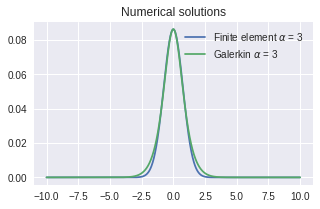

In [55]:
# Now we can construct our RBM for an alpha of our choosing. 
alpha_k = alph
solGaler=phibuilder(coeffs)
lamGaler=energy

alpha_vals = [alpha_k]  

T = np.zeros((len(alpha_vals),m)) 
 
T_evals = np.zeros(len(alpha_vals))

for i,alpha_sample in enumerate(alpha_vals):
    H = construct_H(V,x_array,mass,alpha_sample) # construct the Hamiltonian matrix for given alpha_sample.
    evals, evects = solve(H,x_array,h) # solve the system for evals and evects.
    T[i] = evects[i]/np.linalg.norm(evects[i]) # assign the nth evect to solution array T
    T_evals[i] = evals[i] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'Finite Ele alpha = {alpha_sample}, lambda = {evals[i]}')
    
print(f'QC Galerkin alpha = {alph}, lambda = {lamGaler}')

    

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(len(alpha_vals)):
    
    ax.plot(x_array,(T[i]),label= r'Finite element $\alpha$ = '+str(alpha_vals[i]))

ax.plot(x_array,(phi1),label=r'Galerkin $\alpha$ = '+str(alpha_vals[i]))    
    

ax.set_title('Numerical solutions')

ax.legend()

plt.show()

Phew, that was an adventure! But we were able to successfully reproduce everything we could do on the classical computing side just fine. By utilizing the reduced basis method we were able to vastly reduce the dimensionality of solving our problem in this simple case. For our last adventure we'll try to pull together everything we've built in order to solve a tricky non-linear quantum many-body problem.